# Cloudbutton Geospatial: Water Consumption Workflow

---

In [1]:
import os
os.chdir('/work')

In [2]:
from collections import defaultdict
from cloudbutton_geospatial.io_utils.plot import plot_results
from cloudbutton_geospatial.utils.notebook import date_picker
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from shapely.geometry import Point, MultiPoint, box
from pprint import pprint
import functools
import collections
import datetime
import os
import shutil
import math
import numpy as np
import pandas as pd
import lithops
import requests
import rasterio
import fiona
import json
import random
import re
import tempfile
import concurrent.futures
from IPython.display import Image
import matplotlib.pyplot as plt
from lithops.storage import Storage
from lithops.storage.utils import StorageNoSuchKeyError
from io import BytesIO
from data_cockpit.widget import DataLoaderWidget


## Workflow parameters

Area outside the processed tile that we want to consider for taking SIAM stations into account:

In [3]:
AREA_OF_INFLUENCE = 16000

Lithops Variables:

In [4]:
DATA_BUCKET = 'cloudbutton-wc'
COMPUTE_BACKEND = 'aws_lambda'
STORAGE_BACKEND = 'aws_s3'
STORAGE_PREFIX = 's3://'
RUNTIME = 'cloudbutton-wc:01'
RUNTIME_MEMORY = 2048

In [5]:
storage = lithops.storage.Storage(backend=STORAGE_BACKEND)

In [6]:
data_loader = DataLoaderWidget(storage=storage)

data_loader.display()


HTML(value='\n        <style>\n            .data-loader-widget {\n                background-color: #FFFFFF;\n…

IntProgress(value=0, bar_style='info', description='Testing combinations:', layout=Layout(margin='10px auto', …

In [7]:
optimal_config, best_duration = data_loader.geospatial_widget.get_optimal_configuration()
SPLITS = int(optimal_config['n_tiles'])
runtime_memory_mb = optimal_config['runtime_memory_mb']
ephemeral_storage_mb = optimal_config['ephemeral_storage_mb']
worker_processes = optimal_config['worker_processes']


In [8]:
fexec = lithops.FunctionExecutor(
    backend=COMPUTE_BACKEND,
    storage=STORAGE_BACKEND,
    runtime_memory=RUNTIME_MEMORY,
    ephemeral_storage=ephemeral_storage_mb,
    workers=worker_processes
)

2025-04-10 09:21:30,664 [INFO] config.py:146 -- Lithops v3.5.2.dev0 - Python3.10
2025-04-10 09:21:30,667 [DEBUG] config.py:107 -- Loading configuration from the cloud
2025-04-10 09:21:31,030 [DEBUG] config.py:186 -- Loading Serverless backend module: aws_lambda
2025-04-10 09:21:31,040 [DEBUG] config.py:226 -- Loading Storage backend module: aws_s3
2025-04-10 09:21:31,041 [DEBUG] aws_s3.py:36 -- Creating AWS S3 Client
2025-04-10 09:21:31,236 [INFO] aws_s3.py:59 -- S3 client created - Region: us-east-1
2025-04-10 09:21:31,293 [DEBUG] aws_lambda.py:53 -- Creating AWS Lambda client
2025-04-10 09:21:31,680 [INFO] aws_lambda.py:97 -- AWS Lambda client created - Region: us-east-1
2025-04-10 09:21:31,686 [DEBUG] invokers.py:105 -- ExecutorID 1a9a49-0 - Invoker initialized. Max workers: 1000
2025-04-10 09:21:31,688 [DEBUG] invokers.py:309 -- ExecutorID 1a9a49-0 - Serverless invoker created
2025-04-10 09:21:33,344 [DEBUG] executors.py:164 -- Function executor for aws_lambda created with ID: 1a9a

In [9]:
fexec.config['aws_lambda']['runtime_timeout'] = 900

In [10]:
DTM_PREFIX = 'DTMs/'
DTM_ASC_PREFIX = 'DTMs/asc/'
DTM_GEOTIFF_PREFIX = 'DTMs/geotiff/'

Split tile into square chunks (number of tiles = SPLITS^2):

Correlation coefficient between elevation and temperature:

In [11]:
r = -0.0056

Elevation to interpolate temperature:

In [12]:
zdet = 2000

Day of year to calculate solar irradiation:

In [13]:
date = date_picker(default=datetime.date(2022, 5, 15))

DatePicker(value=datetime.date(2022, 5, 15), description='Pick a Date', step=1)

In [14]:
DAY_OF_YEAR = date.value.timetuple().tm_yday
DAY_OF_YEAR

135

## Data preparation

### SIAM data

In [15]:
siam_data_key = 'siam_data.csv'
try:
    siam_data_head = storage.head_object(bucket=DATA_BUCKET, key=siam_data_key)
    print(f'SIAM meteo data already in storage: {siam_data_head}')
except StorageNoSuchKeyError:
    print('Uploading SIAM meteo data to Object Storage...')
    with open(siam_data_key, 'rb') as f:
        storage.put_object(bucket=DATA_BUCKET, key=siam_data_key, body=f)

SIAM meteo data already in storage: {'x-amz-id-2': 'w3D09ZMuoBcNNMW/ftxX0G9P1Ty2u7he+W6JDanRuU4JHrVl/U2DMwqj0Q/AY8KGrPPX4CMz2KY=', 'x-amz-request-id': 'A6NXF464CV2MCKTV', 'date': 'Thu, 10 Apr 2025 09:21:35 GMT', 'last-modified': 'Thu, 24 Oct 2024 22:21:09 GMT', 'etag': '"8a1fd5da76b1123e66cc0155e6c8f5f7"', 'x-amz-server-side-encryption': 'AES256', 'accept-ranges': 'bytes', 'content-type': 'binary/octet-stream', 'content-length': '3850', 'server': 'AmazonS3'}


### Shapefile

In [16]:
shapefile_key = 'shapefile_murcia.zip'
try:
    shapefile_head = storage.head_object(bucket=DATA_BUCKET, key=shapefile_key)
    print(f'Shapefile already in storage: {siam_data_head}')
except StorageNoSuchKeyError:
    print('Uploading shapefile to Object Storage...')
    with open(shapefile_key, 'rb') as f:
        storage.put_object(bucket=DATA_BUCKET, key=shapefile_key, body=f)

Shapefile already in storage: {'x-amz-id-2': 'w3D09ZMuoBcNNMW/ftxX0G9P1Ty2u7he+W6JDanRuU4JHrVl/U2DMwqj0Q/AY8KGrPPX4CMz2KY=', 'x-amz-request-id': 'A6NXF464CV2MCKTV', 'date': 'Thu, 10 Apr 2025 09:21:35 GMT', 'last-modified': 'Thu, 24 Oct 2024 22:21:09 GMT', 'etag': '"8a1fd5da76b1123e66cc0155e6c8f5f7"', 'x-amz-server-side-encryption': 'AES256', 'accept-ranges': 'bytes', 'content-type': 'binary/octet-stream', 'content-length': '3850', 'server': 'AmazonS3'}


### Digital Terrain Models

Download DTM files for free from http://centrodedescargas.cnig.es/CentroDescargas/buscadorCatalogo.do?codFamilia=MDT05# and put them in `input_DTMs` folder.

In [17]:
dtm_asc_keys = storage.list_keys(bucket=DATA_BUCKET, prefix=DTM_ASC_PREFIX)
# dtm_asc_keys

Find downloaded MDTs:

In [18]:
local_dtm_input = '/work/input_DTMs'
local_dtms = [os.path.join(local_dtm_input, dtm) for dtm in os.listdir(local_dtm_input) if dtm.endswith('.asc')]

def upload_file(file_path):
    key = os.path.join(DTM_ASC_PREFIX, os.path.basename(file_path))
    if key in dtm_asc_keys:
        print(f'Tile {key} already in storage')
        return key
    with open(file_path, 'rb') as f:
        print(f'Uploading {key}...')
        storage.put_object(bucket=DATA_BUCKET, key=key, body=f)
    return key

with concurrent.futures.ThreadPoolExecutor(max_workers=16) as pool:
    result = list(pool.map(upload_file, local_dtms))
    # list(result)

Convert ASCII raster files to Cloud Optimized GeoTIFF:

In [19]:
def asc_to_geotiff(obj, storage):
    asc_file_name = os.path.basename(obj.key)
    tile_id, _ = os.path.splitext(asc_file_name)
    out_path = os.path.join(tempfile.gettempdir(), tile_id + '.tiff')
    out_key = os.path.join(DTM_GEOTIFF_PREFIX, tile_id + '.tiff')

    try:
        out_obj = storage.head_object(bucket=DATA_BUCKET, key=out_key)
    except StorageNoSuchKeyError:
        out_obj = None

    if out_obj:
        print(f'GeoTIFF {tile_id} already exists, skipping...')
        return out_key

    print(f'Converting {tile_id} to GeoTIFF...')
    with rasterio.open(obj.data_stream, 'r') as src:
        profile = src.profile
        # Cloud optimized GeoTiff parameters
        profile.update(driver='GTiff')
        profile.update(blockxsize=256)
        profile.update(blockysize=256)
        profile.update(tiled=True)
        profile.update(compress='deflate')
        profile.update(interleave='band')
        with rasterio.open(out_path, 'w', **profile) as dest:
            dest.write(src.read())

    with open(out_path, 'rb') as f:
        storage.put_object(bucket=DATA_BUCKET, key=out_key, body=f)

    return out_key


In [20]:
_, _ = fexec.map(asc_to_geotiff, os.path.join(STORAGE_PREFIX, DATA_BUCKET, DTM_ASC_PREFIX)).wait()

2025-04-10 09:21:35,424 [INFO] invokers.py:119 -- ExecutorID 1a9a49-0 | JobID M000 - Selected Runtime: runtime-39569a54-9511-4511-8f2b-f33d01765c99:65d1e48c-0a38-4808-9481-3e283677e7f6-amd64 - 2048MB
2025-04-10 09:21:35,426 [DEBUG] storage.py:483 -- Runtime metadata not found in local cache. Retrieving it from storage
2025-04-10 09:21:35,428 [DEBUG] storage.py:487 -- Trying to download runtime metadata from: aws_s3://lithopscloud-bucket-eftk5pvx5np5/lithops.runtimes/aws_lambda/3.5.2.dev0/us-east-1/lithops-worker-f7yr-352dev0-4af07b7c88.meta.json
2025-04-10 09:21:35,494 [DEBUG] storage.py:491 -- Runtime metadata found in storage
2025-04-10 09:21:35,498 [DEBUG] job.py:72 -- ExecutorID 1a9a49-0 | JobID M000 - Calling map on partitions from object storage flow
2025-04-10 09:21:35,499 [DEBUG] partitioner.py:50 -- Parsing input data
2025-04-10 09:21:35,500 [DEBUG] partitioner.py:299 -- Chunk size and chunk number not set
2025-04-10 09:21:35,502 [DEBUG] partitioner.py:422 -- Listing prefixes 

In [21]:
dtm_geotiff_keys = storage.list_keys(bucket=DATA_BUCKET, prefix=DTM_GEOTIFF_PREFIX)
# dtm_geotiff_keys

Get bounds and tile ID for every tile:

In [22]:
def get_tile_meta(obj):
    storage = Storage()
    tile_id = os.path.splitext(os.path.basename(obj.key))[0]
    with rasterio.open(BytesIO(storage.get_cloudobject(obj)), 'r') as src:
        x1, y1 = src.profile['transform'] * (0, 0)
        x2, y2 = src.profile['transform'] * (src.profile['width'], src.profile['height'])
    return tile_id, (x1, y1), (x2, y2)

In [23]:
tiles_meta = fexec.map(get_tile_meta, os.path.join(STORAGE_PREFIX, DATA_BUCKET, DTM_GEOTIFF_PREFIX)).get_result()


2025-04-10 09:21:48,045 [INFO] invokers.py:119 -- ExecutorID 1a9a49-0 | JobID M001 - Selected Runtime: runtime-39569a54-9511-4511-8f2b-f33d01765c99:65d1e48c-0a38-4808-9481-3e283677e7f6-amd64 - 2048MB
2025-04-10 09:21:48,056 [DEBUG] storage.py:472 -- Runtime metadata found in local memory cache
2025-04-10 09:21:48,058 [DEBUG] job.py:72 -- ExecutorID 1a9a49-0 | JobID M001 - Calling map on partitions from object storage flow
2025-04-10 09:21:48,061 [DEBUG] partitioner.py:50 -- Parsing input data
2025-04-10 09:21:48,065 [DEBUG] partitioner.py:299 -- Chunk size and chunk number not set
2025-04-10 09:21:48,068 [DEBUG] partitioner.py:422 -- Listing prefixes in aws_s3://cloudbutton-wc/DTMs/geotiff
2025-04-10 09:21:48,345 [DEBUG] partitioner.py:346 -- Creating 1 partitions from object DTMs/geotiff/PNOA_MDT05_ETRS89_HU30_0976_LID.tiff (53.4MiB)
2025-04-10 09:21:48,346 [DEBUG] partitioner.py:346 -- Creating 1 partitions from object DTMs/geotiff/PNOA_MDT05_ETRS89_HU30_0977_LID.tiff (42.3MiB)
2025-

2025-04-10 09:21:48,513 [DEBUG] invokers.py:390 -- ExecutorID 1a9a49-0 | JobID M001 - Calls 00000 invoked (0.025s) - Activation ID: a1551c31-2198-4d79-a0c0-e5a12d246acf
2025-04-10 09:21:48,520 [DEBUG] invokers.py:390 -- ExecutorID 1a9a49-0 | JobID M001 - Calls 00002 invoked (0.025s) - Activation ID: 38f890b7-7800-4ebe-b46c-02e454067611
2025-04-10 09:21:48,523 [DEBUG] invokers.py:390 -- ExecutorID 1a9a49-0 | JobID M001 - Calls 00001 invoked (0.028s) - Activation ID: d60a77bd-ae4e-4455-83c7-2047b3278879
2025-04-10 09:21:48,524 [DEBUG] invokers.py:390 -- ExecutorID 1a9a49-0 | JobID M001 - Calls 00003 invoked (0.025s) - Activation ID: 10a8312e-c59b-4e9e-85c2-9dd8e1492219
2025-04-10 09:21:48,526 [DEBUG] invokers.py:390 -- ExecutorID 1a9a49-0 | JobID M001 - Calls 00004 invoked (0.025s) - Activation ID: cf438af9-8bcc-49f1-b4e3-315e2e0a830e
2025-04-10 09:22:20,768 [DEBUG] invokers.py:390 -- ExecutorID 1a9a49-0 | JobID M002 - Calls 00004 invoked (0.021s) - Activation ID: e45ec02b-9b87-4826-bf00

In [24]:
# tiles_meta

In [25]:
import ipyleaflet
import ipywidgets
import utm

m = ipyleaflet.Map(center=(38.082906, -1.330466), zoom=9.5)

for tile_id, bound1, bound2 in tiles_meta:
    x1, y1 = bound1
    x2, y2 = bound2
    xc, yc = (x1 + x2) / 2, y1
    
    wgs_bounds_1 = utm.to_latlon(x1, y1, 30, 'S')
    wgs_bounds_2 = utm.to_latlon(x2, y2, 30, 'S')
    # wgs_bounds_c = utm.to_latlon(xc, yc, 30, 'S')

    rectangle = ipyleaflet.Rectangle(bounds=(wgs_bounds_1, wgs_bounds_2))
    m.add_layer(rectangle)    

m.layout.height="750px"

m

Map(center=[38.082906, -1.330466], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [26]:
def data_chunker(obj, n_splits, block_x, block_y, storage):
    tile_key = os.path.basename(obj.key)
    tile_id, _ = os.path.splitext(tile_key)

    storage = Storage()

    with rasterio.open(BytesIO(storage.get_cloudobject(obj))) as src:
        transform = src.transform

        # Compute working window
        step_w = src.width / n_splits
        step_h = src.height / n_splits

        offset_h = round(step_h * block_x)
        offset_w = round(step_w * block_y)

        profile = src.profile

        width = math.ceil(step_w * (block_y + 1) - offset_w)
        height = math.ceil(step_h * (block_x + 1) - offset_h)

        profile.update(width=width)
        profile.update(height=height)

        window = Window(offset_w, offset_h, width, height)

        chunk_file = os.path.join(tempfile.gettempdir(), tile_id + str(block_x) + '_' + str(block_y) + '.tif')
        with rasterio.open(chunk_file, 'w', **profile) as dest:
            dest.write(src.read(window=window))

    with open(chunk_file, 'rb') as f:
        co = storage.put_cloudobject(body=f, bucket=DATA_BUCKET)

    return (tile_key, block_x, block_y, co)

## Raster Data Interpolation

Split data tiles in subtiles for increased parallelism:

In [27]:
iterdata = [(os.path.join(STORAGE_PREFIX, DATA_BUCKET, tile), SPLITS, i, j)
            for i in range(SPLITS) for j in range(SPLITS) for tile in dtm_geotiff_keys]
print(f'Chunking {len(dtm_geotiff_keys)} tiles in {SPLITS * SPLITS} chunks each using {len(iterdata)} functions')
# iterdata

Chunking 5 tiles in 49 chunks each using 245 functions


In [28]:
chunks = fexec.map(data_chunker, iterdata).get_result()


2025-04-10 09:21:59,343 [INFO] invokers.py:119 -- ExecutorID 1a9a49-0 | JobID M002 - Selected Runtime: runtime-39569a54-9511-4511-8f2b-f33d01765c99:65d1e48c-0a38-4808-9481-3e283677e7f6-amd64 - 2048MB
2025-04-10 09:21:59,345 [DEBUG] storage.py:472 -- Runtime metadata found in local memory cache
2025-04-10 09:21:59,351 [DEBUG] job.py:72 -- ExecutorID 1a9a49-0 | JobID M002 - Calling map on partitions from object storage flow
2025-04-10 09:21:59,352 [DEBUG] partitioner.py:50 -- Parsing input data
2025-04-10 09:21:59,356 [DEBUG] partitioner.py:299 -- Chunk size and chunk number not set
2025-04-10 09:21:59,357 [DEBUG] partitioner.py:406 -- Head on object  aws_s3://cloudbutton-wc/DTMs/geotiff//PNOA_MDT05_ETRS89_HU30_0976_LID.tiff
2025-04-10 09:21:59,612 [DEBUG] partitioner.py:346 -- Creating 1 partitions from object DTMs/geotiff/PNOA_MDT05_ETRS89_HU30_0976_LID.tiff (53.4MiB)
2025-04-10 09:21:59,613 [DEBUG] partitioner.py:406 -- Head on object  aws_s3://cloudbutton-wc/DTMs/geotiff//PNOA_MDT05_

In [29]:
chunks                                                                  

[('PNOA_MDT05_ETRS89_HU30_0976_LID.tiff',
  0,
  0,
  <lithops.storage.utils.CloudObject at 0x7ae7600803d0>),
 ('PNOA_MDT05_ETRS89_HU30_0977_LID.tiff',
  0,
  0,
  <lithops.storage.utils.CloudObject at 0x7ae760083520>),
 ('PNOA_MDT05_ETRS89_HU30_0978_LID.tiff',
  0,
  0,
  <lithops.storage.utils.CloudObject at 0x7ae75bf1fdf0>),
 ('PNOA_MDT05_ETRS89_HU30_0997B_LID.tiff',
  0,
  0,
  <lithops.storage.utils.CloudObject at 0x7ae7601c89d0>),
 ('PNOA_MDT05_ETRS89_HU30_0997_LID.tiff',
  0,
  0,
  <lithops.storage.utils.CloudObject at 0x7ae760082ec0>),
 ('PNOA_MDT05_ETRS89_HU30_0976_LID.tiff',
  0,
  1,
  <lithops.storage.utils.CloudObject at 0x7ae7600aac20>),
 ('PNOA_MDT05_ETRS89_HU30_0977_LID.tiff',
  0,
  1,
  <lithops.storage.utils.CloudObject at 0x7ae7601c9270>),
 ('PNOA_MDT05_ETRS89_HU30_0978_LID.tiff',
  0,
  1,
  <lithops.storage.utils.CloudObject at 0x7ae7600835e0>),
 ('PNOA_MDT05_ETRS89_HU30_0997B_LID.tiff',
  0,
  1,
  <lithops.storage.utils.CloudObject at 0x7ae760081c60>),
 ('PNOA_

Compute solar irradiation for a given day of year using GRASS libraries:

In [30]:
def compute_solar_irradiation(inputFile, outputFile, crs='32630'):
    # Define grass working set
    GRASS_GISDB = '/tmp/grassdata'
    #GRASS_GISDB = 'grassdata'
    GRASS_LOCATION = 'GEOPROCESSING'
    GRASS_MAPSET = 'PERMANENT'
    GRASS_ELEVATIONS_FILENAME = 'ELEVATIONS'

    os.environ['GRASSBIN'] = 'grass76'

    from grass_session import Session
    import grass.script as gscript
    import grass.script.setup as gsetup
    from grass.pygrass.modules.shortcuts import general
    from grass.pygrass.modules.shortcuts import raster
    
    os.environ.update(dict(GRASS_COMPRESS_NULLS='1'))

    # Clean previously processed data
    if os.path.isdir(GRASS_GISDB):
        shutil.rmtree(GRASS_GISDB)
    
    with Session(gisdb=GRASS_GISDB, location=GRASS_LOCATION, mapset=GRASS_MAPSET, create_opts='EPSG:32630') as ses:
        # Set project projection to match elevation raster projection
        general.proj(epsg=crs, flags='c') 
        # Load raster file into working directory
        raster.import_(input=inputFile, output=GRASS_ELEVATIONS_FILENAME, flags='o')    
        
        # Set project region to match raster region
        general.region(raster=GRASS_ELEVATIONS_FILENAME, flags='s')    
        # Calculate solar irradiation
        gscript.run_command('r.slope.aspect', elevation=GRASS_ELEVATIONS_FILENAME,
                            slope='slope', aspect='aspect')
        gscript.run_command('r.sun', elevation=GRASS_ELEVATIONS_FILENAME,
                            slope='slope', aspect='aspect', beam_rad='beam',
                            step=1, day=DAY_OF_YEAR)
        
        # Get extraterrestrial irradiation from history metadata
        regex = re.compile(r'\d+\.\d+')
        output = gscript.read_command("r.info", flags="h", map=["beam"])
        splits = str(output).split('\n')
        line = next(filter(lambda line: 'Extraterrestrial' in line, splits))
        extraterrestrial_irradiance = float(regex.search(line)[0])
        
        # Export generated results into a GeoTiff file
        if os.path.isfile(outputFile):
            os.remove(outputFile)

        raster.out_gdal(input='beam', output=outputFile)
        
        return extraterrestrial_irradiance

Get stations contained in the area of interest:

In [31]:
def filter_stations(bounds, stations):
    total_points = MultiPoint([Point(x, y) for x, y in stations[['X', 'Y']].to_numpy()])
    total_points_list = list(total_points.geoms)
    intersection = bounds.buffer(AREA_OF_INFLUENCE).intersection(total_points)
    filtered_stations = [point for point in total_points_list if intersection.contains(point)]

    return stations[[point in filtered_stations for point in total_points_list]]

Inverse Distance Weighting interpolation:

In [32]:
def compute_basic_interpolation(shape, stations, field_value, offset = (0,0)):
    station_pixels = [[pixel[0], pixel[1]] for pixel in stations['pixel'].to_numpy()]
    
    # Get an array where each position represents pixel coordinates
    tile_pixels = np.indices(shape).transpose(1,2,0).reshape(shape[0]*shape[1], 2) + offset
    dist = distance_matrix(station_pixels, tile_pixels)
    weights = np.where(dist == 0, np.finfo('float32').max, 1.0 / dist )
    weights /=  weights.sum(axis=0)
    
    return np.dot(weights.T, stations[field_value].to_numpy()).reshape(shape).astype('float32')

Interpolate temperatures from a subset of the tile:

In [33]:
def radiation_interpolation(tile_key, block_x, block_y, chunk_cloudobject, storage):
    tile_id, _ = os.path.splitext(tile_key)
    print(tile_id)

    # Write tile chunk to file
    chunk_file = os.path.join(tempfile.gettempdir(), tile_id + str(block_x) + '_' + str(block_y) + '.tif')
    print(chunk_file)

    with open(chunk_file, 'wb') as f:
        body = storage.get_cloudobject(chunk_cloudobject)
        f.write(body)

    with rasterio.open(chunk_file, 'r') as chunk_src:
        profile = chunk_src.profile

    extr_chunk_file = os.path.join(tempfile.gettempdir(), tile_id + '_extr_' + str(block_x) + '_' + str(block_y) + '.tif')
    rad_chunk_file = os.path.join(tempfile.gettempdir(), tile_id + '_rad_' + str(block_x) + '_' + str(block_y) + '.tif')

    # Compute solar irradiation from inputFile, creates radiation raster at outputFile
    extraterrestrial_irradiation = compute_solar_irradiation(inputFile=chunk_file, outputFile=rad_chunk_file)

    # Create and store a raster with extraterrestrial irradiation
    with rasterio.open(extr_chunk_file, 'w', **profile) as dest:
        data = np.full((profile['height'], profile['width']), extraterrestrial_irradiation, dtype='float32')
        dest.write(data, 1)

    with open(extr_chunk_file, 'rb') as f:
        extr_co = storage.put_cloudobject(body=f, bucket=DATA_BUCKET)

    with open(rad_chunk_file, 'rb') as f:
        rad_co = storage.put_cloudobject(body=f, bucket=DATA_BUCKET)

    return [(tile_key, 'extr', block_x, block_y, extr_co), (tile_key, 'rad', block_x, block_y, rad_co)]

In [34]:
def map_interpolation(tile_key, block_x, block_y, chunk_cloudobject, data_field, storage):
    tile_id, _ = os.path.splitext(tile_key)

    # Get SIAM meteo data
    siam_stream = storage.get_object(DATA_BUCKET, siam_data_key, stream=True)
    siam_data = pd.read_csv(siam_stream)

    # print(siam_data)

    chunk = storage.get_cloudobject(chunk_cloudobject)

    with rasterio.open(BytesIO(chunk)) as chunk_src:
        transform = chunk_src.transform
        profile = chunk_src.profile

        bounding_rect = box(chunk_src.bounds.left, chunk_src.bounds.top, chunk_src.bounds.right, chunk_src.bounds.bottom)
        filtered = pd.DataFrame(filter_stations(bounding_rect, siam_data))
        #print(filtered)

        if filtered.shape[0] == 0:
            return [(tile_key, data_field, block_x, block_y, None)]

        filtered['pixel'] = filtered.apply(lambda station: rasterio.transform.rowcol(transform, station['X'], station['Y']), axis=1)

        # Interpolate variables from meteo station data, generate raster with result
        dest_chunk_file = os.path.join(tempfile.gettempdir(), tile_id + '_' + data_field + '_' + str(block_x) + '_' + str(block_y) + '.tif')

        with rasterio.open(dest_chunk_file, 'w', **profile) as chunk_dest:
            if data_field == 'temp':
                elevations = chunk_src.read(1)  # Get elevations content
                print(dest_chunk_file)
                interpolation = compute_basic_interpolation(elevations.shape, filtered, 'tdet', (0, 0))
                interpolation += r * (elevations - zdet)
                chunk_dest.write(np.where(elevations == chunk_src.nodata, np.nan, interpolation), 1)
            elif data_field == 'humi':
                interpolation = compute_basic_interpolation((profile['height'], profile['width']), filtered, 'hr', (0, 0))
                chunk_dest.write(interpolation, 1)
            elif data_field == 'wind':
                interpolation = compute_basic_interpolation((profile['height'], profile['width']), filtered, 'v', (0, 0))
                chunk_dest.write(interpolation, 1)
            else:
                raise Exception(f'Unknown data field "{data_field}"')

    # Upload results to storage as Cloudobject
    with open(dest_chunk_file, 'rb') as f:
        co = storage.put_cloudobject(body=f, bucket=DATA_BUCKET)

    return [(tile_key, data_field, block_x, block_y, co)]

Lithops serverless computation:

In [35]:
res_rad = fexec.map(radiation_interpolation, chunks, runtime_memory=2048).get_result()

2025-04-10 09:22:36,289 [INFO] invokers.py:119 -- ExecutorID 1a9a49-0 | JobID M003 - Selected Runtime: runtime-39569a54-9511-4511-8f2b-f33d01765c99:65d1e48c-0a38-4808-9481-3e283677e7f6-amd64 - 2048MB
2025-04-10 09:22:36,292 [DEBUG] storage.py:472 -- Runtime metadata found in local memory cache
2025-04-10 09:22:36,297 [DEBUG] job.py:242 -- ExecutorID 1a9a49-0 | JobID M003 - Serializing function and data
2025-04-10 09:22:36,837 [DEBUG] serialize.py:75 -- Referenced Modules: shutil, io, re, tempfile, numpy, os, grass_session, lithops, rasterio, __main__
2025-04-10 09:22:36,840 [DEBUG] module_dependency.py:109 -- Module 'shutil' is already installed in the runtime, skipping
2025-04-10 09:22:36,841 [DEBUG] module_dependency.py:109 -- Module 'io' is already installed in the runtime, skipping
2025-04-10 09:22:36,842 [DEBUG] module_dependency.py:109 -- Module 're' is already installed in the runtime, skipping
2025-04-10 09:22:36,845 [DEBUG] module_dependency.py:109 -- Module 'tempfile' is alre

2025-04-10 09:22:36,974 [DEBUG] invokers.py:390 -- ExecutorID 1a9a49-0 | JobID M003 - Calls 00000 invoked (0.028s) - Activation ID: a274bd47-d9e4-4b07-840c-054a1e3460b3
2025-04-10 09:22:37,028 [DEBUG] invokers.py:390 -- ExecutorID 1a9a49-0 | JobID M003 - Calls 00020 invoked (0.026s) - Activation ID: 49abef34-c395-400e-a30a-bf54693a05b3
2025-04-10 09:22:36,981 [DEBUG] invokers.py:390 -- ExecutorID 1a9a49-0 | JobID M003 - Calls 00001 invoked (0.031s) - Activation ID: 55169b2c-f94d-4c92-a68d-ccd103aadad8
2025-04-10 09:22:36,982 [DEBUG] invokers.py:390 -- ExecutorID 1a9a49-0 | JobID M003 - Calls 00002 invoked (0.030s) - Activation ID: d929cb28-0137-4dd1-96c2-70e52b12e7d8
2025-04-10 09:22:36,989 [DEBUG] invokers.py:390 -- ExecutorID 1a9a49-0 | JobID M003 - Calls 00007 invoked (0.018s) - Activation ID: e8631d87-21ad-4d6c-8b3e-016828bb309a
2025-04-10 09:22:37,148 [DEBUG] invokers.py:390 -- ExecutorID 1a9a49-0 | JobID M003 - Calls 00044 invoked (0.024s) - Activation ID: d3d82617-a3bf-44c1-8a39

In [36]:
res_temp = fexec.map(map_interpolation, chunks, extra_args=('temp', ), runtime_memory=2048).get_result()

2025-04-10 09:23:22,098 [INFO] invokers.py:119 -- ExecutorID 1a9a49-0 | JobID M004 - Selected Runtime: runtime-39569a54-9511-4511-8f2b-f33d01765c99:65d1e48c-0a38-4808-9481-3e283677e7f6-amd64 - 2048MB
2025-04-10 09:23:22,100 [DEBUG] storage.py:472 -- Runtime metadata found in local memory cache
2025-04-10 09:23:22,110 [DEBUG] job.py:242 -- ExecutorID 1a9a49-0 | JobID M004 - Serializing function and data
2025-04-10 09:23:22,760 [DEBUG] serialize.py:75 -- Referenced Modules: scipy, io, tempfile, numpy, _io, os, lithops, pandas, rasterio, shapely, __main__
2025-04-10 09:23:22,763 [DEBUG] module_dependency.py:109 -- Module 'scipy' is already installed in the runtime, skipping
2025-04-10 09:23:22,764 [DEBUG] module_dependency.py:109 -- Module 'io' is already installed in the runtime, skipping
2025-04-10 09:23:22,766 [DEBUG] module_dependency.py:109 -- Module 'tempfile' is already installed in the runtime, skipping
2025-04-10 09:23:22,767 [DEBUG] module_dependency.py:109 -- Module 'numpy' is 

In [37]:
res_humi = fexec.map(map_interpolation, chunks, extra_args=('humi', ), runtime_memory=2048).get_result()

2025-04-10 09:23:59,575 [INFO] invokers.py:119 -- ExecutorID 1a9a49-0 | JobID M005 - Selected Runtime: runtime-39569a54-9511-4511-8f2b-f33d01765c99:65d1e48c-0a38-4808-9481-3e283677e7f6-amd64 - 2048MB
2025-04-10 09:23:59,578 [DEBUG] storage.py:472 -- Runtime metadata found in local memory cache
2025-04-10 09:23:59,587 [DEBUG] job.py:242 -- ExecutorID 1a9a49-0 | JobID M005 - Serializing function and data
2025-04-10 09:24:00,225 [DEBUG] serialize.py:75 -- Referenced Modules: scipy, io, tempfile, numpy, _io, os, lithops, pandas, rasterio, shapely, __main__
2025-04-10 09:24:00,226 [DEBUG] module_dependency.py:109 -- Module 'scipy' is already installed in the runtime, skipping
2025-04-10 09:24:00,228 [DEBUG] module_dependency.py:109 -- Module 'io' is already installed in the runtime, skipping
2025-04-10 09:24:00,229 [DEBUG] module_dependency.py:109 -- Module 'tempfile' is already installed in the runtime, skipping
2025-04-10 09:24:00,230 [DEBUG] module_dependency.py:109 -- Module 'numpy' is 

In [38]:
res_wind = fexec.map(map_interpolation, chunks, extra_args=('wind', ), runtime_memory=2048).get_result()

2025-04-10 09:24:11,916 [INFO] invokers.py:119 -- ExecutorID 1a9a49-0 | JobID M006 - Selected Runtime: runtime-39569a54-9511-4511-8f2b-f33d01765c99:65d1e48c-0a38-4808-9481-3e283677e7f6-amd64 - 2048MB
2025-04-10 09:24:11,922 [DEBUG] storage.py:472 -- Runtime metadata found in local memory cache
2025-04-10 09:24:11,927 [DEBUG] job.py:242 -- ExecutorID 1a9a49-0 | JobID M006 - Serializing function and data
2025-04-10 09:24:12,558 [DEBUG] serialize.py:75 -- Referenced Modules: scipy, io, tempfile, numpy, _io, os, lithops, pandas, rasterio, shapely, __main__
2025-04-10 09:24:12,559 [DEBUG] module_dependency.py:109 -- Module 'scipy' is already installed in the runtime, skipping
2025-04-10 09:24:12,560 [DEBUG] module_dependency.py:109 -- Module 'io' is already installed in the runtime, skipping
2025-04-10 09:24:12,562 [DEBUG] module_dependency.py:109 -- Module 'tempfile' is already installed in the runtime, skipping
2025-04-10 09:24:12,563 [DEBUG] module_dependency.py:109 -- Module 'numpy' is 

In [39]:
res_flatten = []
for l in [res_rad, res_temp, res_humi, res_wind]:
    for elem in l:
        for sub_elem in elem:
            res_flatten.append(sub_elem)

In [40]:
# res_flatten

In [41]:
grouped_chunks = collections.defaultdict(list)

for chunk_result in res_flatten:
    tile_key, data_field, block_x, block_y, co = chunk_result
    grouped_chunks[(tile_key, data_field)].append((block_x, block_y, co))

In [42]:
# grouped_chunks

Join split subsets into a tile:

In [43]:
def merge_blocks(tile_data, chunks, storage):
    from rasterio.windows import Window

    tile_key, data_field = tile_data

    cobjs = [tup[2] for tup in chunks]
    if None in cobjs:
        return None

    # Get width and height from original tile
    source_tile_key = os.path.join(DTM_GEOTIFF_PREFIX, tile_key)
    with rasterio.open(BytesIO(storage.get_object(bucket=DATA_BUCKET, key=source_tile_key))) as source_tile:
        height = source_tile.profile['height']
        width = source_tile.profile['width']

    # Open first object to obtain profile metadata
    with rasterio.open(BytesIO(storage.get_cloudobject(chunks[0][2]))) as chunk_src:
        profile = chunk_src.profile
        profile.update(width=width)
        profile.update(height=height)

    # Iterate each object and print its block into the destination file
    merged_file = os.path.join(tempfile.gettempdir(), data_field + '_' + tile_key)
    with rasterio.open(merged_file, 'w', **profile) as dest:
        for chunk in chunks:
            j, i, co = chunk
            with rasterio.open(BytesIO(storage.get_cloudobject(co))) as src:
                step_w = math.floor(width / SPLITS)
                step_h = math.floor(height / SPLITS)
                curr_window = Window(round(step_w * i), round(step_h * j), src.width, src.height)
                content = src.read(1)
                dest.write(content, 1, window=curr_window)

    output_key = os.path.join(DTM_PREFIX, data_field, tile_key)
    with open(merged_file, 'rb') as out_file:
        storage.put_object(bucket=DATA_BUCKET, key=output_key, body=out_file)

    return output_key

Combine previous split subsets:

In [44]:
iterdata = []
for (tile_id, data_field), chunks in grouped_chunks.items():
    iterdata.append(((tile_id, data_field), chunks))

In [45]:
tiles_merged = fexec.map(merge_blocks, iterdata, runtime_memory=2048).get_result()

2025-04-10 09:24:25,330 [INFO] invokers.py:119 -- ExecutorID 1a9a49-0 | JobID M007 - Selected Runtime: runtime-39569a54-9511-4511-8f2b-f33d01765c99:65d1e48c-0a38-4808-9481-3e283677e7f6-amd64 - 2048MB
2025-04-10 09:24:25,334 [DEBUG] storage.py:472 -- Runtime metadata found in local memory cache
2025-04-10 09:24:25,337 [DEBUG] job.py:242 -- ExecutorID 1a9a49-0 | JobID M007 - Serializing function and data
2025-04-10 09:24:25,372 [DEBUG] serialize.py:75 -- Referenced Modules: io, rasterio, tempfile, math, __main__, _io, os
2025-04-10 09:24:25,374 [DEBUG] module_dependency.py:109 -- Module 'io' is already installed in the runtime, skipping
2025-04-10 09:24:25,375 [DEBUG] module_dependency.py:109 -- Module 'rasterio' is already installed in the runtime, skipping
2025-04-10 09:24:25,375 [DEBUG] module_dependency.py:109 -- Module 'tempfile' is already installed in the runtime, skipping
2025-04-10 09:24:25,376 [DEBUG] module_dependency.py:172 -- Module '_io' is built-in. Skipping.
2025-04-10 09

In [46]:
tile_keys_merged = set([os.path.basename(t) for t in tiles_merged])

In [47]:
# tile_keys_merged

## Computation of potential evaporation

In [48]:
def compute_crop_evapotranspiration(temperatures,
                                    humidities,
                                    wind_speeds,
                                    external_radiations,
                                    global_radiations,
                                    KCs):
    gamma = 0.665*101.3/1000
    eSat = 0.6108 * np.exp((17.27*temperatures)/(temperatures+237.3))
    delta = 4098 * eSat / np.power((temperatures + 237.3),2)
    eA = np.where(humidities < 0, 0, eSat * humidities / 100)     # Avoid sqrt of a negative number
    T4 = 4.903 * np.power((273.3 + temperatures),4)/1000000000
    rSrS0 = global_radiations/(external_radiations * 0.75)
    rN = 0.8* global_radiations-T4*(0.34-0.14*np.sqrt(eA))*((1.35*rSrS0)-0.35)
    den = delta + gamma *(1 + 0.34* wind_speeds)
    tRad = 0.408 * delta * rN / den
    tAdv = gamma * (900/(temperatures+273))*wind_speeds * (eSat - eA)/den
    return ((tRad + tAdv) * 7 * KCs).astype('float32')

In [49]:
vineyard = ['VI', 'VO', 'VF', 'FV', 'CV' ]
olive_grove = ['OV', 'VO', 'OF', 'FL', 'OC']
fruit = ['FY', 'VF', 'OF', 'FF', 'CF']
nuts = ['FS', 'FV', 'FL', 'FF', 'CS' ]
citrus = ['CI', 'CV', 'OC', 'CF', 'CS' ]

def get_kc(feature):
    # TODO: Get more precise values of Kc
    print(feature['properties'].keys())
    # sigpac_use = feature['properties']['uso_sigpac']
    sigpac_use = 'FF'
    if sigpac_use in vineyard:
        # Grapes for wine - 0.3, 0.7, 0.45
        return 0.7  
    if sigpac_use in olive_grove:
        # Olive grove - ini: 0.65, med: 0.7, end: 0.7
        return 0.7 
    if sigpac_use in fruit:
        # Apples, Cherries, Pears - 0.45, 0.95, 0.7
        return 0.95
    if sigpac_use in nuts:
        # Almonds - 0.4, 0.9, 0.65
        return 0.9
    if sigpac_use in citrus:
        # Citrus, without ground coverage - 0.7, 0.65, 0.7
        return 0.65
    
    return None

In [50]:
def get_geometry_window(src, geom_bounds):
    left, bottom, right, top = geom_bounds
    src_left, src_bottom, src_right, src_top = src.bounds
    window = src.window(max(left,src_left), max(bottom,src_bottom), min(right,src_right), min(top,src_top))
    window_floored = window.round_offsets(op='floor', pixel_precision=3)
    w = math.ceil(window.width + window.col_off - window_floored.col_off)
    h = math.ceil(window.height + window.row_off - window_floored.row_off)
    return Window(window_floored.col_off, window_floored.row_off, w, h)     

In [51]:
def compute_evapotranspiration_by_shape(tem, hum, win, rad, extrad, dst):

    import fiona
    from shapely.geometry import shape, box
    from rasterio import features

    non_arable_land = ['AG', 'CA', 'ED', 'FO', 'IM', 'PA', 'PR', 'ZU', 'ZV']

    #with fiona.open('zip://home/docker/shape.zip') as shape_src:
    with fiona.open('zip:///tmp/shape.zip') as shape_src:
        for feature in shape_src.filter(bbox=tem.bounds):
            KC = get_kc(feature)
            if KC is not None:
                geom = shape(feature['geometry'])
                window = get_geometry_window(tem, geom.bounds)
                win_transform = rasterio.windows.transform(window, tem.transform)
                # Convert shape to raster matrix
                image = features.rasterize([geom],
                                           out_shape=(window.height, window.width),
                                           transform = win_transform,
                                           fill = 0,
                                           default_value = 1).astype('bool')
                # Get values to compute evapotranspiration
                temperatures = tem.read(1, window=window)
                humidities = hum.read(1, window=window)
                wind_speeds = win.read(1, window=window)
                # Convert from W to MJ (0.0036)
                global_radiations = rad.read(1, window=window) * 0.0036
                external_radiations = extrad.read(1, window=window) * 0.0036
                KCs = np.full(temperatures.shape, KC)
                # TODO: compute external radiation
                #external_radiations = np.full(temperatures.shape, 14)
                # TODO: compute global radiation
                # global_radiations = np.full(temperatures.shape, 10)
                etc = compute_crop_evapotranspiration(
                        temperatures,
                        humidities,
                        wind_speeds,
                        external_radiations,
                        global_radiations,
                        KCs
                )
                etc[temperatures == tem.nodata] = dst.nodata
                etc[np.logical_not(image)] = dst.nodata
                dst.write(etc + dst.read(1, window=window), 1, window=window)

In [52]:
def compute_global_evapotranspiration(tem, hum, win, rad, extrad, dst):    
    for ji, window in tem.block_windows(1):
        bounds = rasterio.windows.bounds(window, tem.transform)
        temperatures = tem.read(1, window=window)
        humidities = hum.read(1, window=window)
        wind_speeds = win.read(1, window=window)
         # Convert from W to MJ (0.0036)
        global_radiations = rad.read(1, window=window) * 0.0036
        external_radiations = extrad.read(1, window=window) * 0.0036
        # TODO: compute external radiation
        #external_radiations = np.full(temperatures.shape, 14)
        # TODO: compute global radiation
        # global_radiations = np.full(temperatures.shape, 10)
        # TODO: compute KCs
        KCs = np.full(temperatures.shape, 1)
        etc = compute_crop_evapotranspiration(
                temperatures,
                humidities,
                wind_speeds,
                external_radiations,
                global_radiations,
                KCs
        )
        dst.write(np.where(temperatures == tem.nodata, dst.nodata, etc), 1, window=window)

In [53]:
def combine_calculations(tile_key, storage):
    from functools import partial
      
    # Download shapefile
    shapefile = storage.get_object(bucket=DATA_BUCKET, key='shapefile_murcia.zip', stream=True)

    with open('/tmp/shape.zip', 'wb') as shapf:
        for chunk in iter(partial(shapefile.read, 200 * 1024 * 1024), ''):
            if not chunk:
                break
            shapf.write(chunk)
    try:
        temp = storage.get_object(bucket=DATA_BUCKET, key=os.path.join(DTM_PREFIX, 'temp', tile_key))
        humi = storage.get_object(bucket=DATA_BUCKET, key=os.path.join(DTM_PREFIX, 'humi', tile_key))
        rad = storage.get_object(bucket=DATA_BUCKET, key=os.path.join(DTM_PREFIX, 'rad', tile_key))
        extrad = storage.get_object(bucket=DATA_BUCKET, key=os.path.join(DTM_PREFIX, 'extr', tile_key))
        wind = storage.get_object(bucket=DATA_BUCKET, key=os.path.join(DTM_PREFIX, 'wind', tile_key))
    except StorageNoSuchKeyError:
        print("Storage error")
        return None
    
    output_file = os.path.join(tempfile.gettempdir(), 'eva' + '_' + tile_key)
    with rasterio.open(BytesIO(temp)) as temp_raster:
        with rasterio.open(BytesIO(humi)) as humi_raster:
            with rasterio.open(BytesIO(rad)) as rad_raster:
                with rasterio.open(BytesIO(extrad)) as extrad_raster:
                    with rasterio.open(BytesIO(wind)) as wind_raster:
                        profile = temp_raster.profile
                        profile.update(nodata=0)
                        with rasterio.open(output_file, 'w+', **profile) as dst:
#                             compute_global_evapotranspiration(temp_raster, humi_raster, wind_raster,
#                                                               rad_raster, extrad_raster, dst)
                            compute_evapotranspiration_by_shape(temp_raster, humi_raster, wind_raster,
                                                                rad_raster, extrad_raster, dst)
    
    output_key = os.path.join(DTM_PREFIX, 'eva', tile_key)
    with open(output_file, 'rb') as output_f:
        storage.put_object(bucket=DATA_BUCKET, key=output_key, body=output_f)
    return output_key

In [54]:
res_eva = fexec.map(combine_calculations, tile_keys_merged, runtime_memory=2048).get_result()

2025-04-10 09:24:57,835 [INFO] invokers.py:119 -- ExecutorID 1a9a49-0 | JobID M008 - Selected Runtime: runtime-39569a54-9511-4511-8f2b-f33d01765c99:65d1e48c-0a38-4808-9481-3e283677e7f6-amd64 - 2048MB
2025-04-10 09:24:57,838 [DEBUG] storage.py:472 -- Runtime metadata found in local memory cache
2025-04-10 09:24:57,841 [DEBUG] job.py:242 -- ExecutorID 1a9a49-0 | JobID M008 - Serializing function and data
2025-04-10 09:24:57,858 [DEBUG] serialize.py:75 -- Referenced Modules: io, tempfile, numpy, _io, os, lithops, rasterio, shapely, __main__, fiona, math, functools
2025-04-10 09:24:57,859 [DEBUG] module_dependency.py:109 -- Module 'io' is already installed in the runtime, skipping
2025-04-10 09:24:57,861 [DEBUG] module_dependency.py:109 -- Module 'tempfile' is already installed in the runtime, skipping
2025-04-10 09:24:57,862 [DEBUG] module_dependency.py:109 -- Module 'numpy' is already installed in the runtime, skipping
2025-04-10 09:24:57,864 [DEBUG] module_dependency.py:172 -- Module '_

2025-04-10 09:24:57,984 [DEBUG] monitor.py:429 -- ExecutorID 1a9a49-0 - Starting Storage job monitor


In [55]:
res_eva

['DTMs/eva/PNOA_MDT05_ETRS89_HU30_0997_LID.tiff',
 'DTMs/eva/PNOA_MDT05_ETRS89_HU30_0997B_LID.tiff',
 'DTMs/eva/PNOA_MDT05_ETRS89_HU30_0978_LID.tiff',
 'DTMs/eva/PNOA_MDT05_ETRS89_HU30_0976_LID.tiff',
 'DTMs/eva/PNOA_MDT05_ETRS89_HU30_0977_LID.tiff']

---

In [56]:
fexec.plot(dst=fexec.executor_id)

2025-03-26 14:03:44,425 [INFO] executors.py:570 -- ExecutorID f430a7-0 - Creating execution plots


In [57]:
fexec.clean(clean_cloudobjects=True)

In [58]:
fexec.job_summary()

2025-03-26 14:03:45,757 [WARNING] executors.py:723 -- Could not log job: aws_lambda backend isn't supported by this function.


In [59]:
len(dtm_asc_keys)

5

In [60]:
input_sz = 0
for input_key in dtm_asc_keys:
    meta = storage.head_object(bucket=DATA_BUCKET, key=input_key)
    input_sz += int(meta['content-length'])

In [61]:
input_sz

245091390

---

## Visualization of results

In [62]:
%matplotlib inline


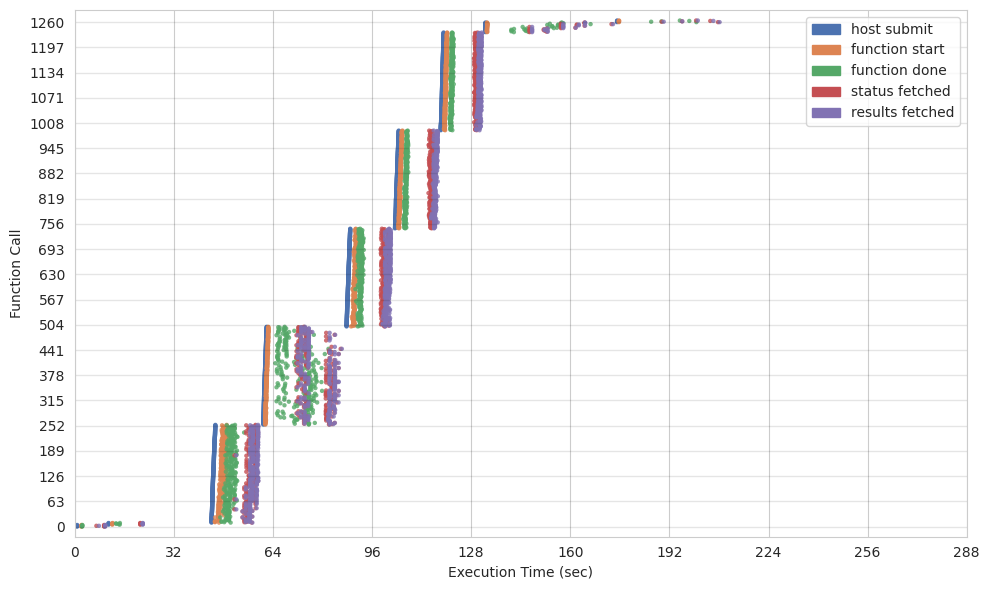

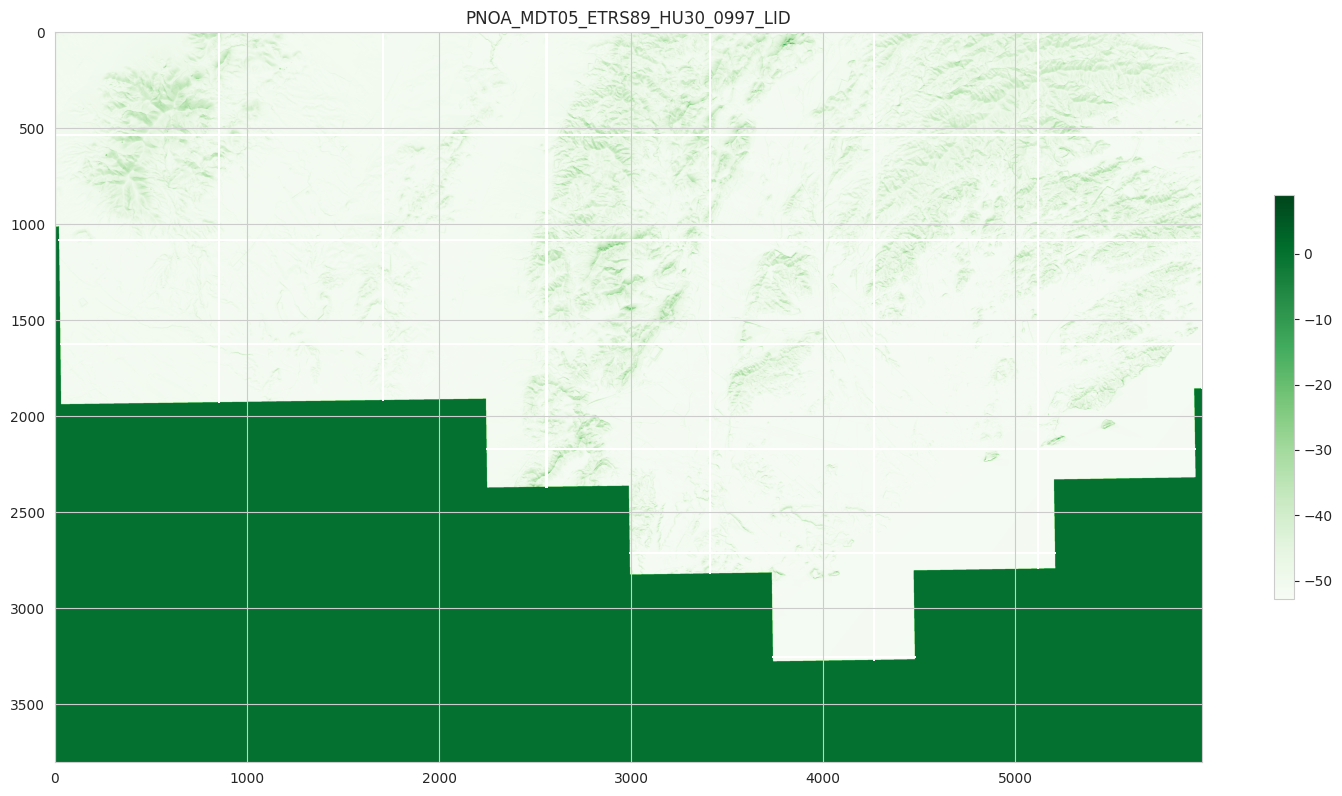

In [63]:
from matplotlib import pyplot as plt

tile = res_eva[0]
tile_key = os.path.basename(tile)
tile_id, _ = os.path.splitext(tile_key)
fig, ax = plt.subplots()

with rasterio.open(BytesIO(storage.get_object(bucket=DATA_BUCKET, key=tile))) as src:
    arr = src.read(1, out_shape=(src.height, src.width))
    ax.set_title(tile_id)
    img = ax.imshow(arr, cmap='Greens')
    fig.colorbar(img, shrink=0.5)

fig.set_size_inches(18.5, 10.5)
plt.show()

# obj.seek(0)

---